# STAN models results summary

Imports

In [1]:
from cmdstanpy import CmdStanModel
import os
import numpy as np
import pandas as pd
from datetime import datetime
import pickle
import cmdstanpy
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt

/Users/anuszka/Projects/jointErrorCMD/venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Read the MCMC fit object from csv files

In [22]:
model = 'sonata_rt_regression_test'
# path = '../cmd_results/stahl/spe/new'
path = '../../results/pram_results/sonata'

In [23]:
fit = cmdstanpy.from_csv(path=f'{path}/{model}')

ValueError: Invalid or corrupt Stan CSV output file, 

In [62]:
print(fit.diagnose())

Processing csv files: ../plgrid_results/cond_models/sonata/drift_boundary_pre3_tbb/wiener_drift_boundary_pre2_tbb_model-20240704040448.csv, ../plgrid_results/cond_models/sonata/drift_boundary_pre3_tbb/wiener_drift_boundary_pre2_tbb_model-20240618045947.csv, ../plgrid_results/cond_models/sonata/drift_boundary_pre3_tbb/wiener_drift_boundary_pre2_tbb_model-20240701142330.csv, ../plgrid_results/cond_models/sonata/drift_boundary_pre3_tbb/wiener_drift_boundary_pre2_tbb_model-20240621051258.csv

Checking sampler transitions treedepth.
2 of 8000 (0.03%) transitions hit the maximum treedepth limit of 12, or 2^12 leapfrog steps.
Trajectories that are prematurely terminated due to this limit will result in slow exploration.
For optimal performance, increase this limit.

Checking sampler transitions for divergences.
351 of 8000 (4.39%) transitions ended with a divergence.
These divergent transitions indicate that HMC is not fully able to explore the posterior distribution.
Try increasing adapt del

## Results summary

### Save draws

In [63]:
# fit_df = fit.draws_pd()
# fit_df.to_csv(f'{path}/{model}/results/{model}_samples.csv')

### Create and save the summary

mean, stdv, percentiles, n_effects, r_hats, bayes factors

In [64]:
def calculate_bayes_factor_participant_level(
        fit_df, 
        parameters_list, 
        prior_distribution, 
        hierarchical=False
):
    prior_kde_0 = calculate_hierarchical_prior_kde(prior_distribution, N=100000)(0)
    
    participants_bf_01 = []

    for participants_parameter in parameters_list:
        participant_bf_01 = calculate_bayes_factor(fit_df, participants_parameter, prior_kde_0)
        participants_bf_01.append(participant_bf_01)

    return np.array(participants_bf_01).flatten()

In [65]:
def calculate_hierarchical_prior_kde(hyper_prior_distributions, N = 100000):
    if isinstance(hyper_prior_distributions, list):
        prior_samples = []
        for hyper_prior in hyper_prior_distributions:
            mean_hyper_prior = hyper_prior['mean']
            sd_hyper_prior = hyper_prior['sd']

            mean_samples = np.random.normal(loc=mean_hyper_prior['loc'], scale=mean_hyper_prior['scale'], size=(N,))
            sd_samples = np.random.gamma(shape = sd_hyper_prior['shape'], scale=sd_hyper_prior['scale'], size=(N,))

            for i in range(0,N):
                prior_sample = np.random.normal(loc=mean_samples[i], scale=sd_samples[i], size=None)
                prior_samples.append(prior_sample)
        prior_samples = np.array(prior_samples)
                
    else:
        mean_hyper_prior = hyper_prior_distributions['mean']
        sd_hyper_prior = hyper_prior_distributions['sd']
        
        mean_samples = np.random.normal(loc=mean_hyper_prior['loc'], scale=mean_hyper_prior['scale'], size=(N,))
        sd_samples = np.random.gamma(shape = sd_hyper_prior['shape'], scale=sd_hyper_prior['scale'], size=(N,))
        
        prior_samples = []
        for i in range(0,N):
            prior_sample = np.random.normal(loc=mean_samples[i], scale=sd_samples[i], size=None)
            prior_samples.append(prior_sample)
        prior_samples = np.array(prior_samples)
        
    # Prior density of hierarchical effect parameters
    prior_density = stats.gaussian_kde(prior_samples)
    
    return prior_density

In [66]:
def calculate_bayes_factor(fit_df, parameter, prior_kde):
    parameter_samples = fit_df[parameter].to_numpy()

    # Estimate density curves from samples
    parameter_kde = stats.gaussian_kde(parameter_samples)

    # Calculate Bayes Factors 01, evidence for the null hypothesis
    bayes_factor_01 = parameter_kde(0) / prior_kde

    return bayes_factor_01

In [67]:
def get_summary_with_bayes_factor(fit, priors_dict, variables_to_track):
    fit_df = fit.draws_pd()
    bayes_factors = dict()
    
    for parameter_name in priors_dict.keys():
        prior_kde, is_hierarchical = priors_dict[parameter_name]
    
        if is_hierarchical:
            parameters_list = [variable for variable in variables_to_track if parameter_name in variable ]
            
            participants_bf_01 = calculate_bayes_factor_participant_level(
                fit_df,
                parameters_list=parameters_list,
                prior_distribution = prior_kde,
                hierarchical=True
            )
            bayes_factors_hierarchical = dict(zip(parameters_list, participants_bf_01))
            bayes_factors.update(bayes_factors_hierarchical)
        else:
            if isinstance(prior_kde, list):
                prior_kde = np.mean(prior_kde)
                
            bf_01 = calculate_bayes_factor(
                fit_df, 
                parameter=parameter_name,
                prior_kde = prior_kde,
            )
            bayes_factors_population = dict(zip([parameter_name], bf_01))
            bayes_factors.update(bayes_factors_population)
        
    summary_df = fit.summary(percentiles=(2, 98))
    bayes_factors_df = pd.DataFrame.from_dict(bayes_factors, orient='index', columns=['Bayes_factor'])
    result_df = pd.concat([summary_df, bayes_factors_df], axis=1)

    return result_df

Define priors

In [68]:
# columns: prior, is hierarchical || model = drift_boundary
priors_dict = {
    'participants_alpha_cond':[{
        'mean': {'loc':0, "scale":1},
        'sd': {'shape':1, "scale":1},
    }, True],
    'participants_alpha_ne':[{
        'mean': {'loc':0, "scale":0.2},
        'sd': {'shape':.3, "scale":1},
    }, True],
    'participants_alpha_ne_pre_acc':[{
        'mean': {'loc':0, "scale":0.2},
        'sd': {'shape':.3, "scale":1},
    }, True],
    'participants_alpha_ern':[[{
        'mean': {'loc':0, "scale":0.2},
        'sd': {'shape':.3, "scale":1},
    }, {
        'mean': {'loc':0, "scale":0.2},
        'sd': {'shape':.3, "scale":1},
    }], True],
    'participants_alpha_crn':[[{
        'mean': {'loc':0, "scale":0.2},
        'sd': {'shape':.3, "scale":1},
    }, {
        'mean': {'loc':0, "scale":0.2},
        'sd': {'shape':.3, "scale":1},
    }], True],
    'participants_delta_cond': [{
        'mean': {'loc':0, "scale":2},
        'sd': {'shape':1, "scale":1},
    }, True],
    'participants_delta_ne': [{
        'mean': {'loc':0, "scale":.5},
        'sd': {'shape':.3, "scale":1},
    }, True],
    'participants_delta_ne_pre_acc':[{
        'mean': {'loc':0, "scale":0.5},
        'sd': {'shape':.3, "scale":1},
    }, True],
    'participants_delta_ern':[[{
        'mean': {'loc':0, "scale":0.2},
        'sd': {'shape':.3, "scale":1},
    }, {
        'mean': {'loc':0, "scale":0.2},
        'sd': {'shape':.3, "scale":1},
    }], True],
    'participants_delta_crn':[[{
        'mean': {'loc':0, "scale":0.2},
        'sd': {'shape':.3, "scale":1},
    }, {
        'mean': {'loc':0, "scale":0.2},
        'sd': {'shape':.3, "scale":1},
    }], True],
    'alpha_cond': [stats.norm.pdf(0, loc=0, scale=1), False],
    'alpha_ne': [stats.norm.pdf(0, loc=0, scale=0.2), False],
    'alpha_ern': [[stats.norm.pdf(0, loc=0, scale=0.2), stats.norm.pdf(0, loc=0, scale=0.2)], False],
    'alpha_crn': [[stats.norm.pdf(0, loc=0, scale=0.2), stats.norm.pdf(0, loc=0, scale=0.2)], False],
    'delta_cond': [stats.norm.pdf(0, loc=0, scale=2), False],
    'delta_ne': [stats.norm.pdf(0, loc=0, scale=.5), False],
    'delta_ern': [[stats.norm.pdf(0, loc=0, scale=0.5), stats.norm.pdf(0, loc=0, scale=0.5)], False],
    'delta_crn': [[stats.norm.pdf(0, loc=0, scale=0.5), stats.norm.pdf(0, loc=0, scale=0.5)], False],
    
    'alpha_pre_acc': [stats.norm.pdf(0, loc=0, scale=0.2), False],
    'alpha_ne_pre_acc': [stats.norm.pdf(0, loc=0, scale=0.2), False],
    'alpha_ne_cond': [stats.norm.pdf(0, loc=0, scale=0.2), False],
    'alpha_pre_acc_cond':[stats.norm.pdf(0, loc=0, scale=0.2), False],
    'alpha_ne_pre_acc_cond':[stats.norm.pdf(0, loc=0, scale=0.2), False],
   
    'delta_pre_acc': [stats.norm.pdf(0, loc=0, scale=.5), False],
    'delta_ne_pre_acc': [stats.norm.pdf(0, loc=0, scale=.5), False],
    'delta_ne_cond': [stats.norm.pdf(0, loc=0, scale=.5), False],
    'delta_pre_acc_cond':[stats.norm.pdf(0, loc=0, scale=.5), False],
    'delta_ne_pre_acc_cond':[stats.norm.pdf(0, loc=0, scale=.5), False],
}
# priors_dict = {
#     'participants_alpha_ne':[{
#         'mean': {'loc':0, "scale":0.2},
#         'sd': {'shape':.3, "scale":1},
#     }, True],
#     'participants_alpha_ne_pre_acc':[{
#         'mean': {'loc':0, "scale":0.2},
#         'sd': {'shape':.3, "scale":1},
#     }, True],
#     'participants_alpha_ern':[[{
#         'mean': {'loc':0, "scale":0.2},
#         'sd': {'shape':.3, "scale":1},
#     }, {
#         'mean': {'loc':0, "scale":0.2},
#         'sd': {'shape':.3, "scale":1},
#     }], True],
#     'participants_alpha_crn':[[{
#         'mean': {'loc':0, "scale":0.2},
#         'sd': {'shape':.3, "scale":1},
#     }, {
#         'mean': {'loc':0, "scale":0.2},
#         'sd': {'shape':.3, "scale":1},
#     }], True],
#     'participants_delta_ne': [{
#         'mean': {'loc':0, "scale":.5},
#         'sd': {'shape':.3, "scale":1},
#     }, True],
#     'participants_delta_ne_pre_acc':[{
#         'mean': {'loc':0, "scale":0.5},
#         'sd': {'shape':.3, "scale":1},
#     }, True],
#     'participants_delta_ern':[[{
#         'mean': {'loc':0, "scale":0.2},
#         'sd': {'shape':.3, "scale":1},
#     }, {
#         'mean': {'loc':0, "scale":0.2},
#         'sd': {'shape':.3, "scale":1},
#     }], True],
#     'participants_delta_crn':[[{
#         'mean': {'loc':0, "scale":0.2},
#         'sd': {'shape':.3, "scale":1},
#     }, {
#         'mean': {'loc':0, "scale":0.2},
#         'sd': {'shape':.3, "scale":1},
#     }], True],
#     'alpha_ne': [stats.norm.pdf(0, loc=0, scale=0.2), False],
#     'alpha_ern': [[stats.norm.pdf(0, loc=0, scale=0.2), stats.norm.pdf(0, loc=0, scale=0.2)], False],
#     'alpha_crn': [[stats.norm.pdf(0, loc=0, scale=0.2), stats.norm.pdf(0, loc=0, scale=0.2)], False],
#     'delta_ne': [stats.norm.pdf(0, loc=0, scale=.5), False],
#     'delta_ern': [[stats.norm.pdf(0, loc=0, scale=0.5), stats.norm.pdf(0, loc=0, scale=0.5)], False],
#     'delta_crn': [[stats.norm.pdf(0, loc=0, scale=0.5), stats.norm.pdf(0, loc=0, scale=0.5)], False],
    
#     'alpha_pre_acc': [stats.norm.pdf(0, loc=0, scale=0.2), False],
#     'alpha_ne_pre_acc': [stats.norm.pdf(0, loc=0, scale=0.2), False],
   
#     'delta_pre_acc': [stats.norm.pdf(0, loc=0, scale=.5), False],
#     'delta_ne_pre_acc': [stats.norm.pdf(0, loc=0, scale=.5), False],
# }

In [69]:
model_variables = list(fit.method_variables().keys()) + ['chain__', 'iter__', 'draw__']
variables_to_track = fit.draws_pd().columns.to_numpy()
variables_to_track = [variable for variable in variables_to_track if ('log_lik' not in variable and variable not in model_variables)]

try:
    summary = get_summary_with_bayes_factor(fit, priors_dict, variables_to_track)
    summary.to_csv(f'{path}/{model}/results/{model}_summary_with_bf_plgrid_test_6-chains.csv')
except Exception as e:
    print(e)
    print('Saving summary without bayes factors')
    summary = fit.summary()
    summary.to_csv(f'{path}/{model}/results/{model}_summary.csv')

### Calculate WAIC

In [70]:
def waic(log_likelihood):
    """Calculates the Watanabe-Akaike information criteria.
    Calculates pWAIC1 and pWAIC2
    according to http://www.stat.columbia.edu/~gelman/research/published/waic_understand3.pdf
    Parameters
    ----------
    pointwise : bool, default to False
        By default, gives the averaged waic.
        Set to True is you want additional waic per observation.
    Returns
    -------
    out: dict
        Dictionary containing lppd (log pointwise predictive density),
        p_waic, waic, waic_se (standard error of the waic), and
        pointwise_waic (when `pointwise` is True).
    """

    N = log_likelihood.shape[1]
    likelihood = np.exp(log_likelihood)

    mean_l = np.mean(likelihood, axis=0) # N observations

    pointwise_lppd = np.log(mean_l)
    lppd = np.sum(pointwise_lppd)

    pointwise_var_l = np.var(log_likelihood, axis=0) # N observations
    var_l = np.sum(pointwise_var_l)

    pointwise_waic = - 2*pointwise_lppd +  2*pointwise_var_l
    waic = -2*lppd + 2*var_l
    waic_se = np.sqrt(N * np.var(pointwise_waic))

    model_statistics = {'lppd':lppd,
           'p_waic':var_l,
           'waic':waic,
           'waic_se':waic_se}
    return model_statistics

In [71]:
fit_df = fit.draws_pd()

log_likelihood_columns = [col for col in fit_df.columns if 'log_lik' in col]
log_likelihood = fit_df[log_likelihood_columns].to_numpy()

model_statistics = waic(log_likelihood)
model_statistics_df = pd.DataFrame.from_dict(model_statistics, orient='index', columns=['value'])

display(model_statistics_df)

model_statistics_df.to_csv(f'{path}/{model}/results/{model}_model_statistics_6-chains.csv')

value
lppd      63958.593920
p_waic     1989.403399
waic    -123938.381042
waic_se     664.289785

## Plots

In [72]:
model_variables = list(fit.method_variables().keys()) + ['chain__', 'iter__', 'draw__']
variables_to_track = fit.draws_pd().columns.to_numpy()
variables_to_track = [variable for variable in variables_to_track if ('log_lik' not in variable and variable not in model_variables)]
base_variables_to_track = [variable for variable in variables_to_track if 'participant' not in variable] + ['chain__', 'iter__'] 

fit_df = fit.draws_pd()
fit_df_params = fit_df[base_variables_to_track]
melted_fit_df_params = pd.melt(fit_df_params, id_vars=['chain__', 'iter__'], var_name='parameter', value_name='value')

### Draw chains

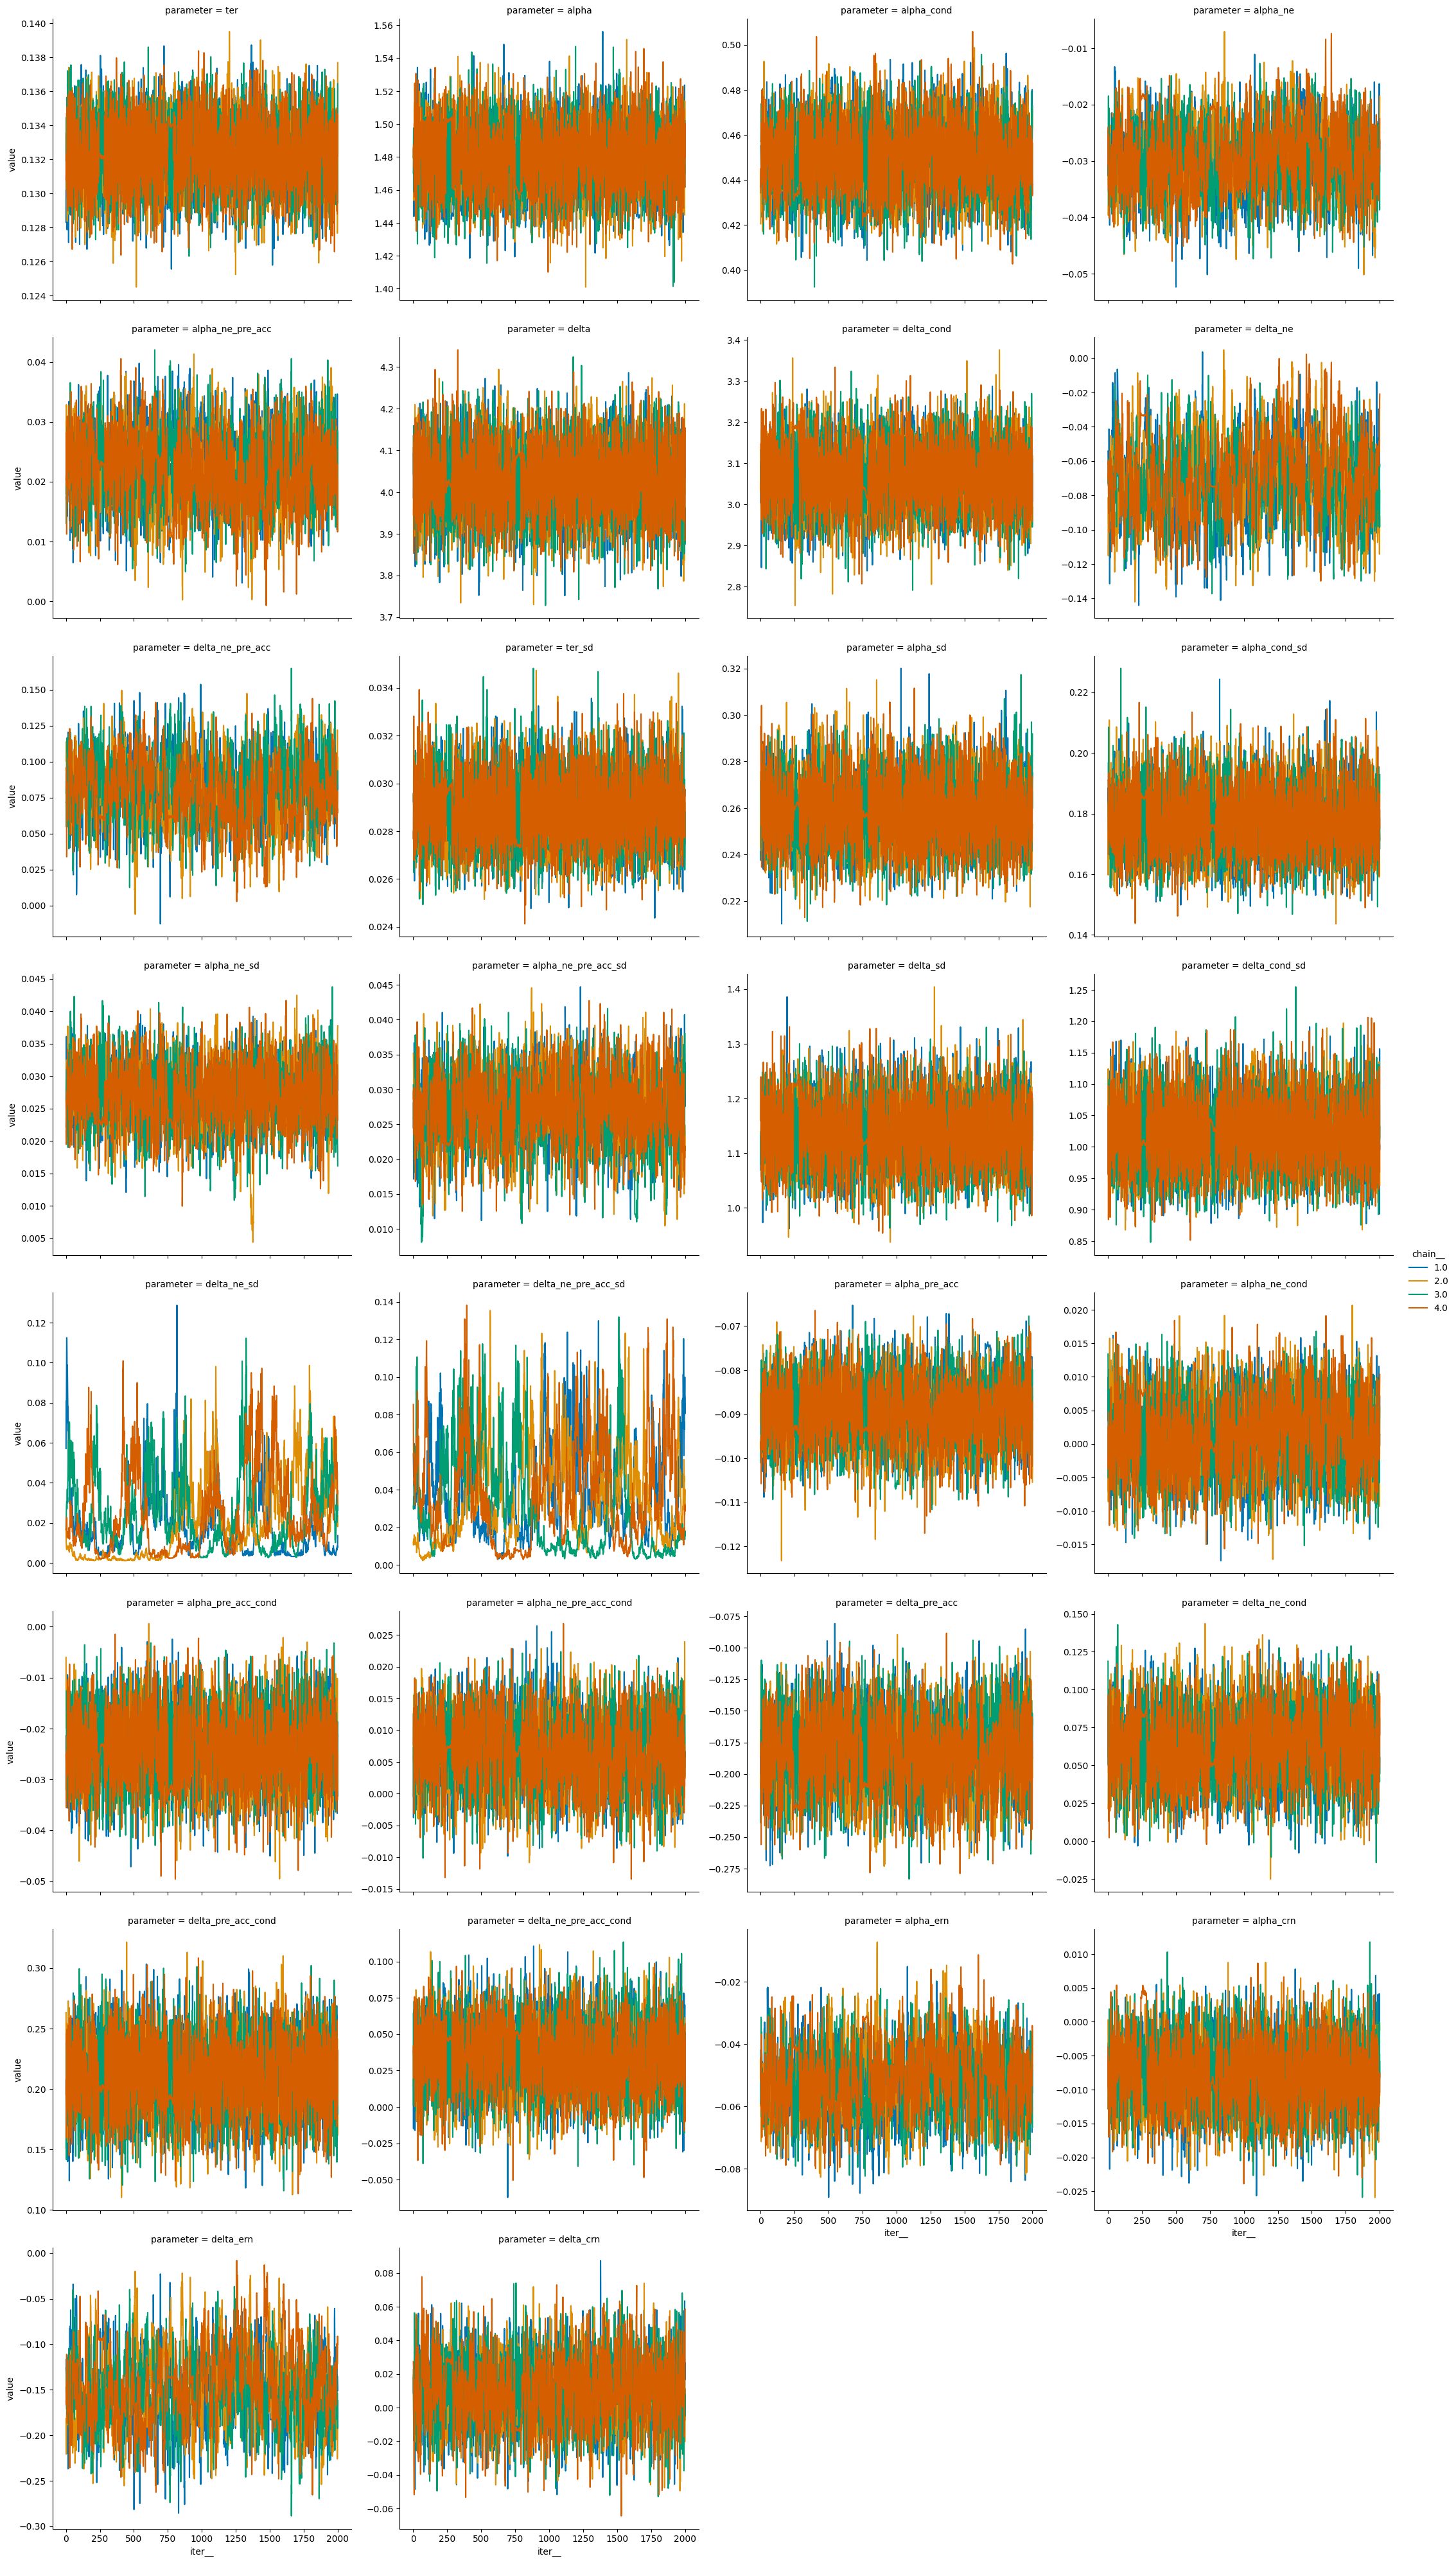

In [73]:
g = sns.relplot(
    data=melted_fit_df_params,
    x="iter__", 
    y="value",
    hue="chain__", 
    col="parameter",
    kind="line",
    col_wrap=4,
    height=5, 
    aspect=1.1, 
    facet_kws=dict(sharex=True, sharey=False),
    palette='colorblind'
)

fig = plt.gcf()

plt.savefig(f'{path}/{model}/results/{model}_chains-6.png', bbox_inches='tight')

### Draw base parameters distributions

In [74]:
# # Function to plot KDE with CI
# def plot_kde_with_colored_ci(data, **kwargs):
#     kde = sns.kdeplot(data=data['value'], **kwargs)

#     # Extract the KDE line data
#     x, y = kde.get_lines()[0].get_data()
#     # kde.remove()

#     # Calculate the 5th and 95th percentiles
#     lower = np.percentile(data['value'], 5)
#     upper = np.percentile(data['value'], 95)

#     # Plot the entire KDE
#     plt.plot(x, y, color='b')

#     # Fill the area between the 5th and 95th percentiles
#     plt.fill_between(x, y, where=(x >= lower) & (x <= upper), color='g', alpha=0.5)

#     # Draw vertical lines for percentiles and mean
#     mean = np.mean(data['value'])
#     # plt.axvline(lower, color='k', linestyle='--')
#     # plt.axvline(upper, color='k', linestyle='--')
#     plt.axvline(mean, color='r', linestyle='-')

# # Create the FacetGrid
# g = sns.FacetGrid(melted_fit_df_params, col="parameter", col_wrap=4, sharey=False, sharex=False,)

# # Map the plot_kde_with_colored_ci function to each facet
# g.map_dataframe(plot_kde_with_colored_ci)

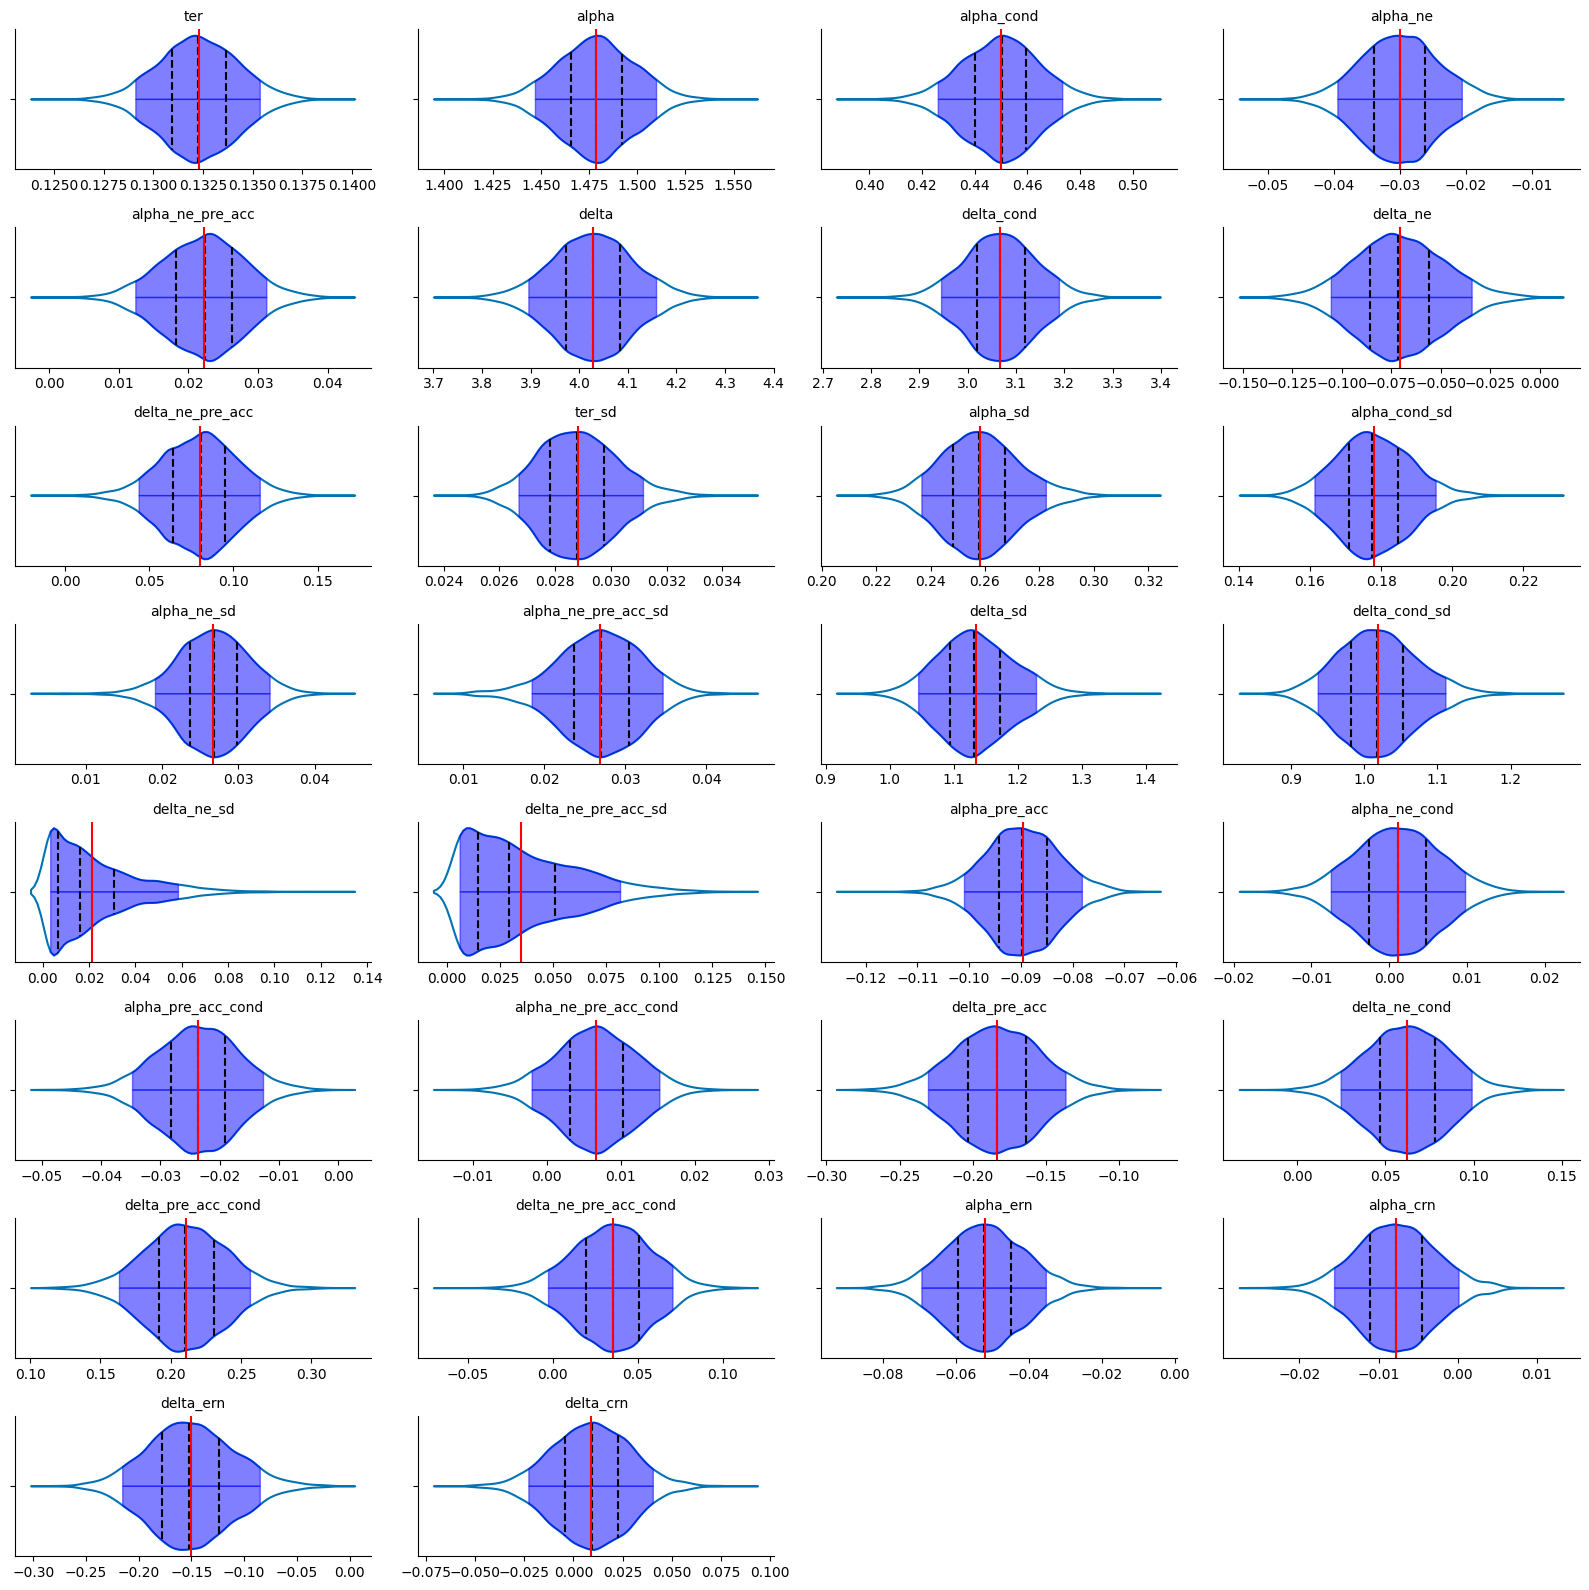

In [75]:
def plot_violin_with_colored_ci(data, **kwargs):
    subset = data
    lower = np.percentile(subset['value'], 5)
    upper = np.percentile(subset['value'], 95)
    mean = np.mean(subset['value'])
    
    violin = sns.violinplot(x='value', data=data, fill=False, inner='quart', **kwargs)
    path_data = violin.get_children()[0].get_paths()
    x = path_data[0].vertices[:, 0]
    y = path_data[0].vertices[:, 1]    

    plt.fill_between(x, y, where=(x >= lower) & (x <= upper), color='blue', alpha=0.5)
    
    for l in violin.lines:
        l.set_linestyle('--')
        l.set_linewidth(1.5)
        l.set_color('black')
    
    plt.axvline(mean, color='r', linestyle='-')

g = sns.FacetGrid(
    melted_fit_df_params, 
    col="parameter", 
    sharex=False, 
    sharey=False, 
    col_wrap=4,
    palette='colorblind',
    aspect=2,
    height=2,
)
g.set_titles(col_template="{col_name}")
g.map_dataframe(plot_violin_with_colored_ci)
g.set_ylabels("")
g.set_xlabels("")

g.fig.tight_layout()

fig = plt.gcf()
plt.savefig(f'{path}/{model}/results/{model}_distributions_6-chains.png', bbox_inches='tight')

### Pair-plots of base parameters
To check cross-parameter correlations

In [76]:
base_variables_to_track = [variable for variable in variables_to_track if 'participant' not in variable]
fit_df = fit.draws_pd()
fit_df_params = fit_df[base_variables_to_track]

g = sns.PairGrid(fit_df_params)
g.map_upper(sns.histplot)
g.map_lower(sns.kdeplot, fill=True)
g.map_diag(sns.histplot, kde=True)

g.fig.tight_layout()
fig = plt.gcf()
plt.savefig(f'{path}/{model}/results/{model}_pair_plots_6-chains.png', bbox_inches='tight')

### Bayes factors distributions

In [77]:
summary_copy = summary.copy()
summary_copy['parameter_name'] = summary_copy.index.str.extract(r'([a-zA-Z_]+(?:_[a-zA-Z]+)*)', expand=False)
summary_copy.groupby(['parameter_name']).agg(['min', 'max', 'median']).to_csv(f'{path}/{model}/results/{model}_parameters_aggegation_6-chains.csv')

summary_copy_random_effects = summary_copy[(~summary_copy['Bayes_factor'].isna()) & (summary_copy['parameter_name'].str.contains('participants', case=False, na=False))]
summary_copy_random_effects.reset_index(inplace=True)
summary_copy_random_effects = summary_copy_random_effects.sort_values(by=['parameter_name', 'Bayes_factor'])

/home/anna/Work/jointError_cmd_test/venv/lib/python3.9/site-packages/seaborn/axisgrid.py:718: UserWarning: Using the pointplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


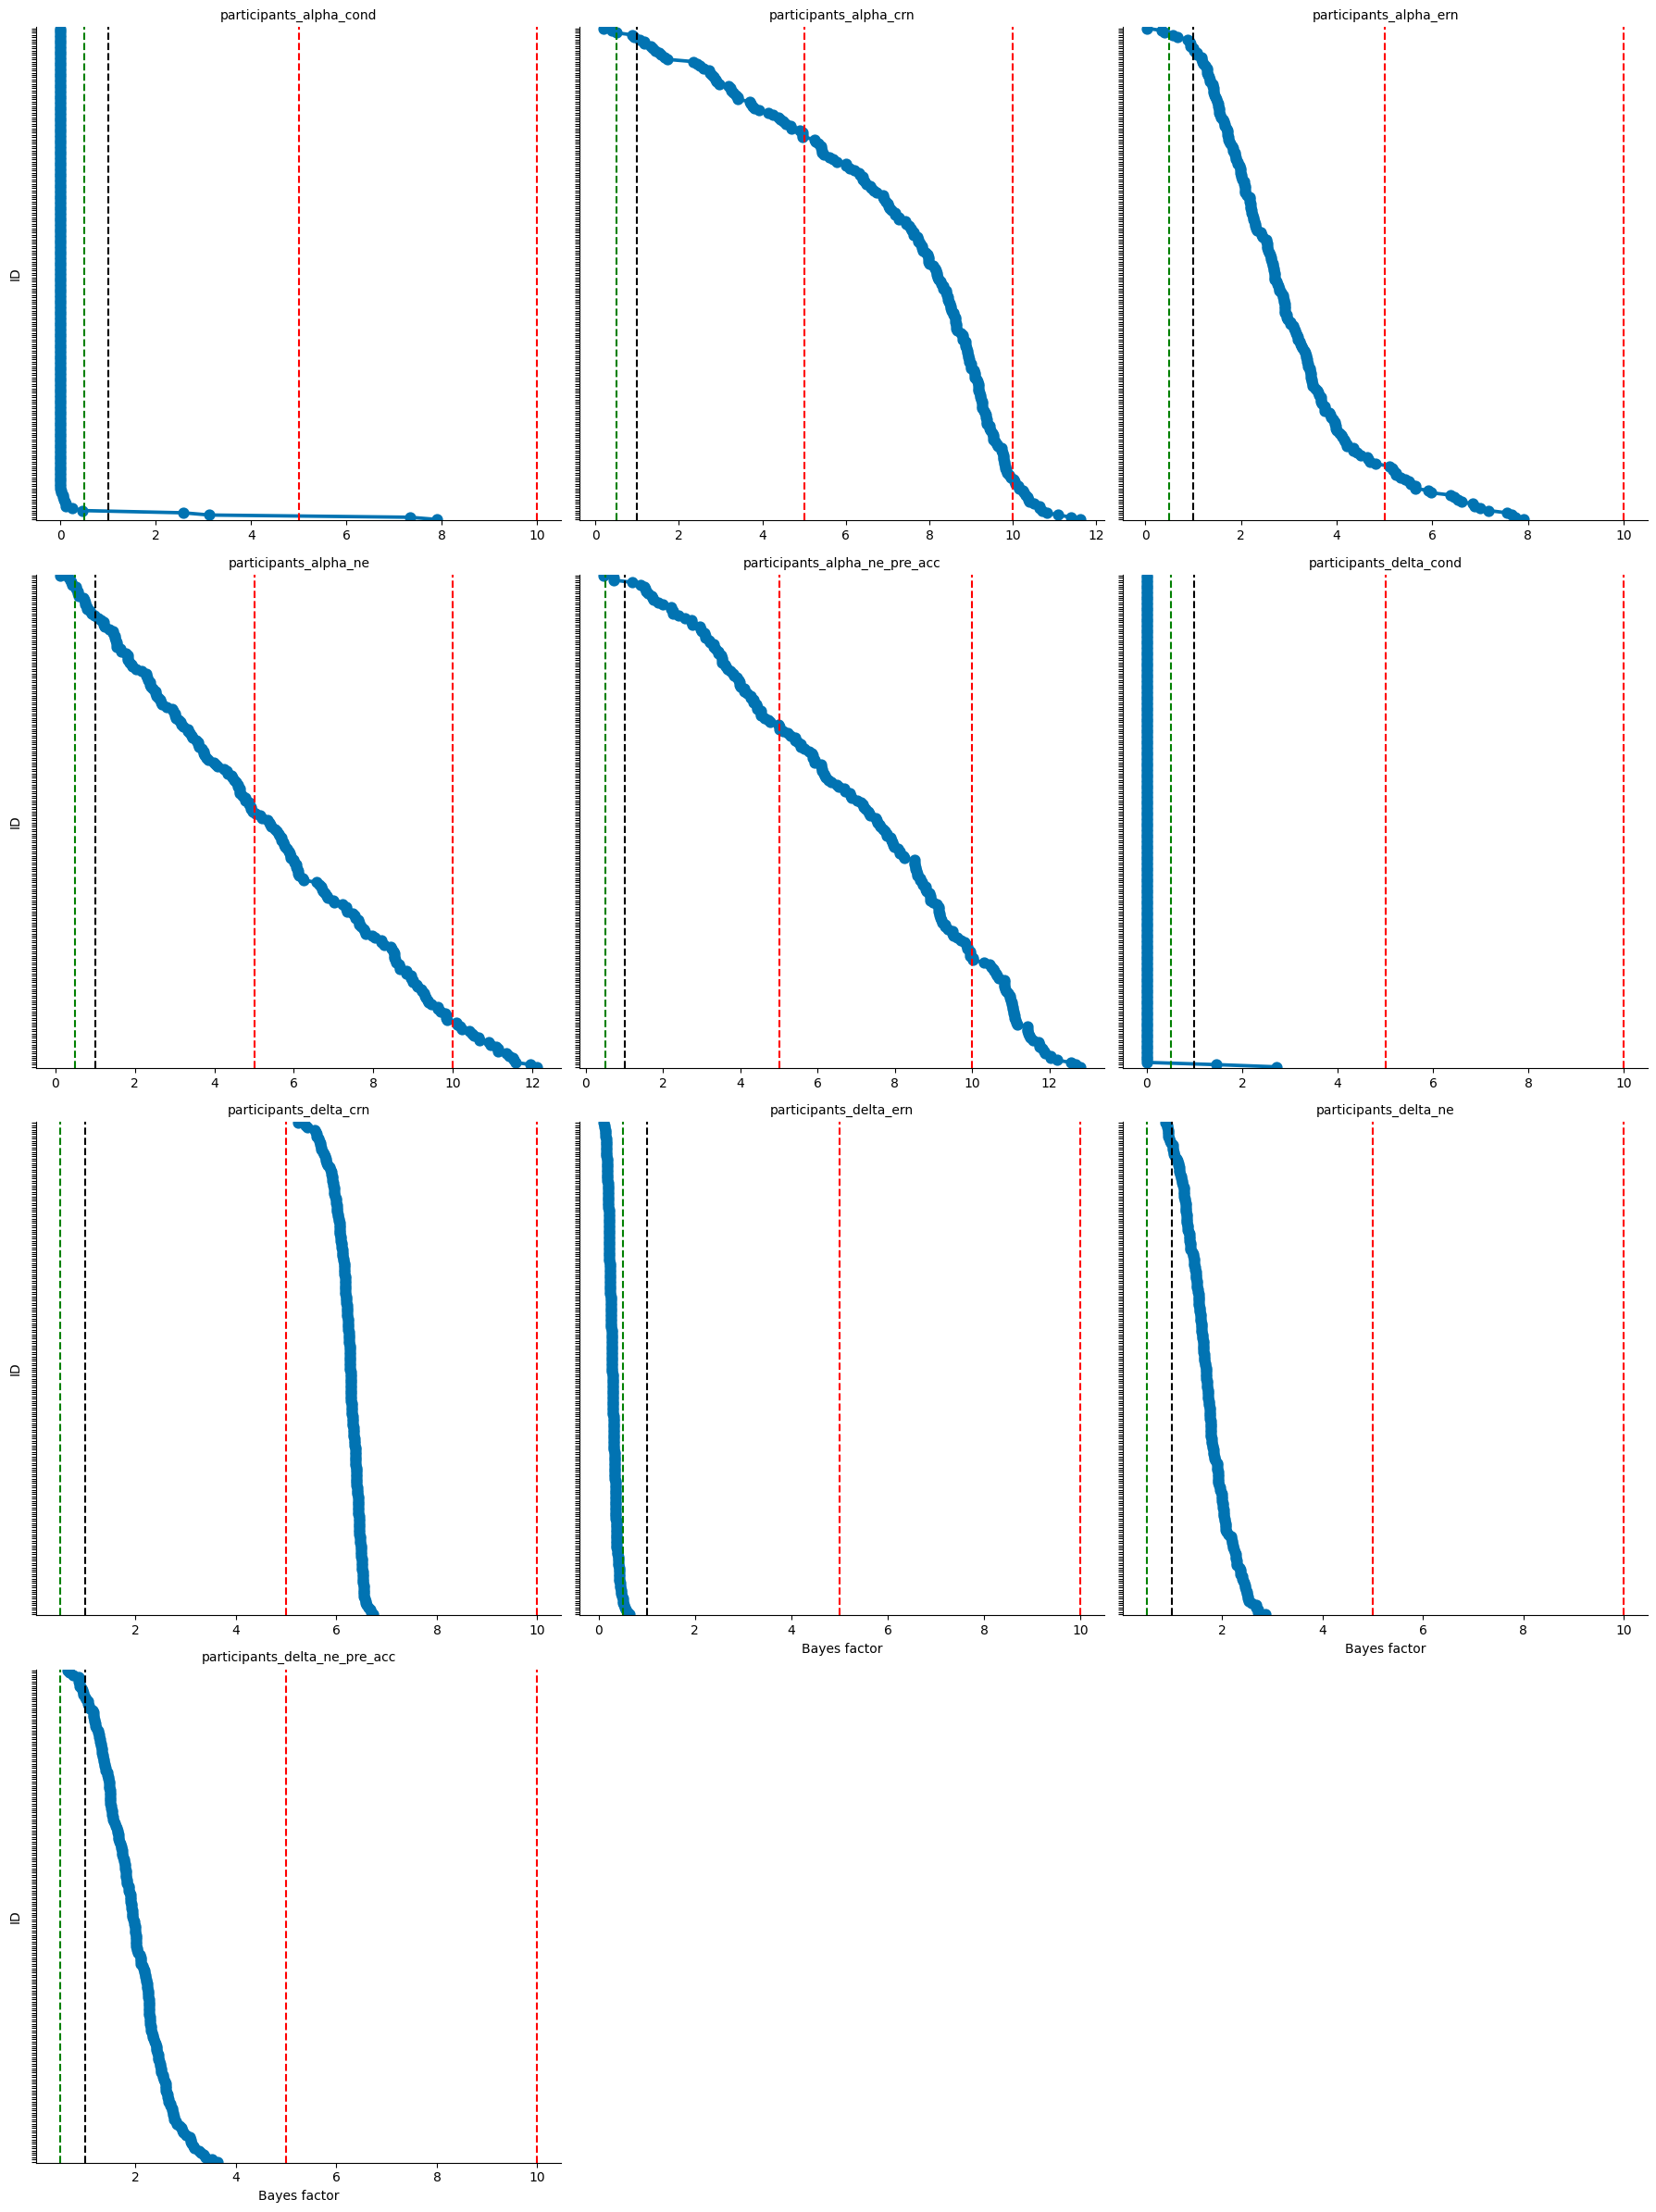

In [78]:
sns.set_palette("colorblind")

g = sns.FacetGrid(
    summary_copy_random_effects, 
    col='parameter_name', 
    col_wrap=3, 
    sharey=False,
    sharex=False,
    aspect=1,
    height=6,
)

g.map(
    sns.pointplot, 
    'Bayes_factor', 
    'index', 
)

g.set_yticklabels([])
g.set_axis_labels("Bayes factor", "ID")
g.set_titles(col_template="{col_name}")

# Add vertical lines at x-values 0.1 and 10
def add_vertical_lines(x, color, linestyle):
    plt.axvline(x=x, color=color, linestyle=linestyle)
    
g.map(add_vertical_lines, color='g', linestyle='--', x=0.5)
g.map(add_vertical_lines, color='black', linestyle='--', x=1)
g.map(add_vertical_lines, color='r', linestyle='--', x=10)
g.map(add_vertical_lines, color='r', linestyle='--', x=5)


g.fig.tight_layout()

fig = plt.gcf()
plt.savefig(f'{path}/{model}/results/{model}_random_effects_bfs_6-chains.png', bbox_inches='tight')

### Effects distributions

In [79]:
model_variables = list(fit.method_variables().keys()) + ['chain__', 'iter__', 'draw__']
variables_to_track = fit.draws_pd().columns.to_numpy()
variables_to_track = [variable for variable in variables_to_track if ('log_lik' not in variable and variable not in model_variables)] + ['chain__', 'iter__'] 

fit_df = fit.draws_pd()
fit_df_params = fit_df[variables_to_track]
melted_fit_df_params = pd.melt(fit_df_params, id_vars=['chain__', 'iter__'], var_name='parameter', value_name='value')
melted_fit_df_params['parameter_name'] = melted_fit_df_params['parameter'].str.extract(r'([a-zA-Z_]+(?:_[a-zA-Z]+)*)', expand=False)

random_effects = melted_fit_df_params[(~melted_fit_df_params['value'].isna()) & (melted_fit_df_params['parameter_name'].str.contains('participants', case=False, na=False))]
random_effects.reset_index(inplace=True)
# random_effects = random_effects.sort_values(by=['parameter_name', 'Mean'])

# Group by 'parameter_name' and calculate mean of 'value'
mean_values = random_effects.groupby('parameter')['value'].mean().reset_index()
merged_df = pd.merge(random_effects, mean_values, on='parameter', suffixes=('', '_mean'))

# # Sort by the mean of 'value'
grouped_df_sorted = merged_df.sort_values(by=['parameter_name', 'value_mean'])

/home/anna/Work/jointError_cmd_test/venv/lib/python3.9/site-packages/seaborn/axisgrid.py:718: UserWarning: Using the pointplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


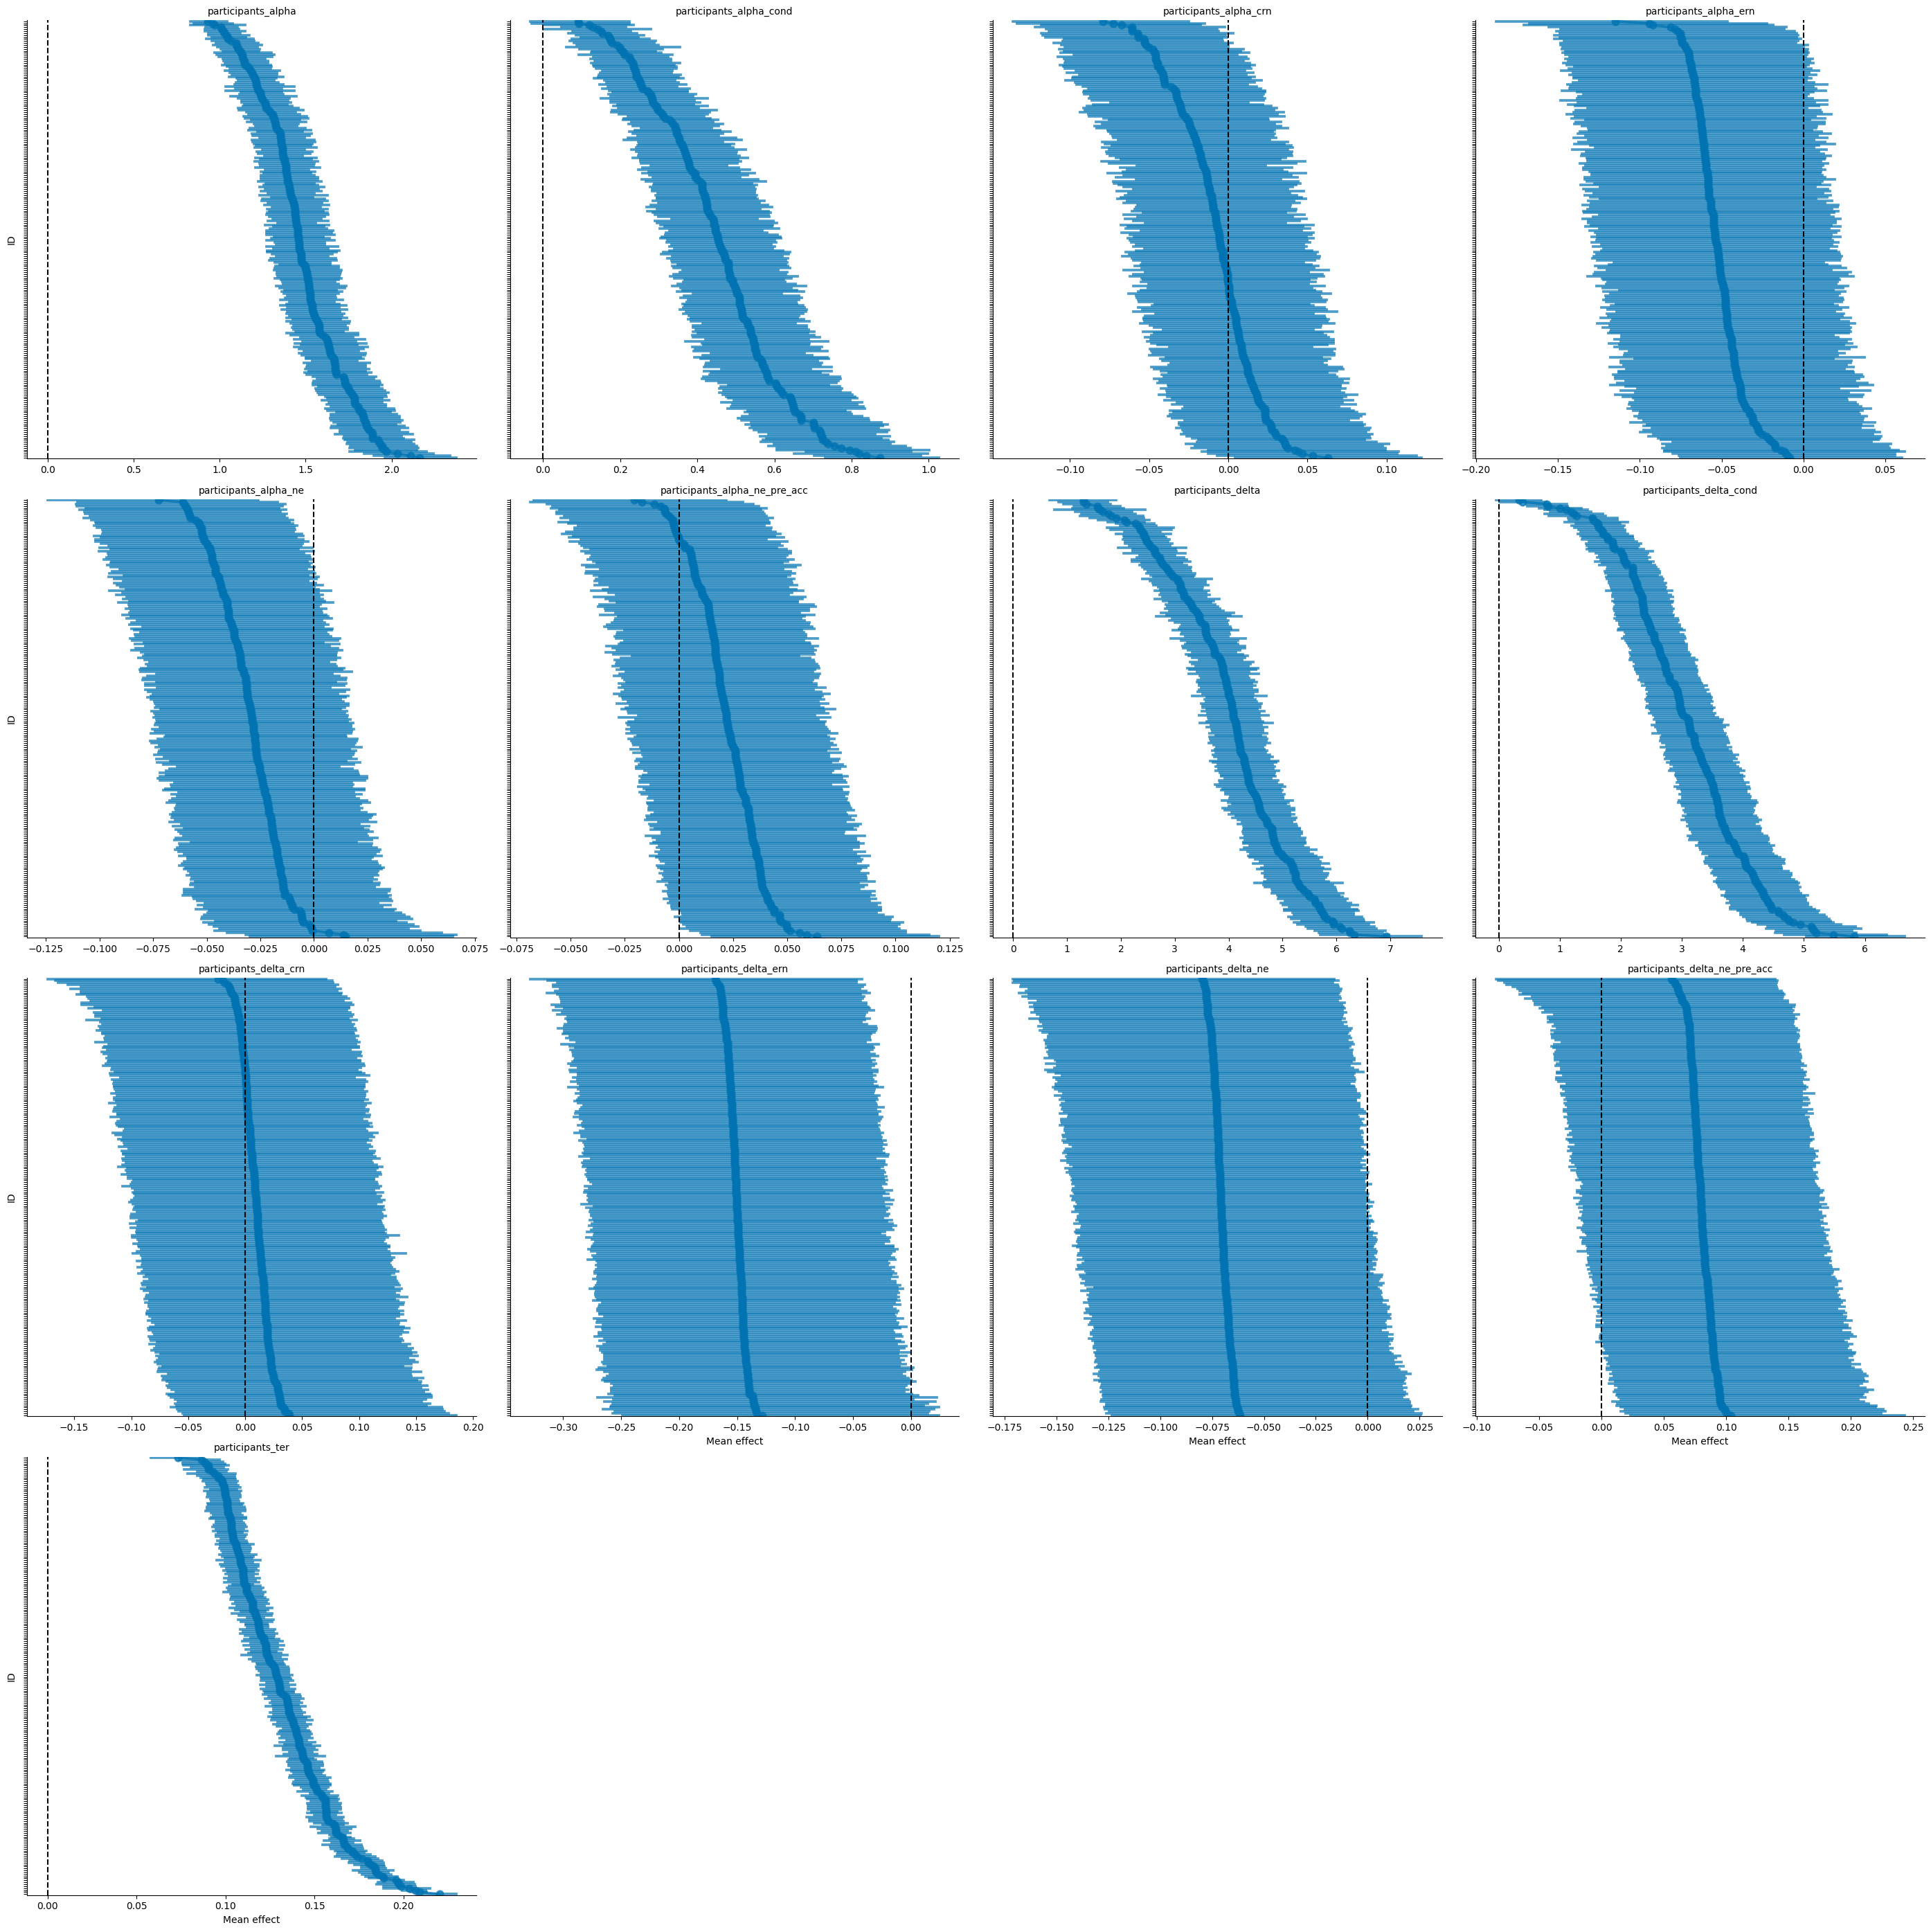

In [80]:
sns.set_palette("colorblind")

g = sns.FacetGrid(
    grouped_df_sorted, 
    col='parameter_name', 
    col_wrap=4, 
    sharey=False,
    sharex=False,
    aspect=1,
    height=7,
)

g.map(
    sns.pointplot, 
    'value', 
    'parameter',
    errorbar=("pi", 95),
)

for ax in g.axes:
    for line in ax.lines:
        line.set_alpha(0.7)
  
g.set_yticklabels([])
g.set_axis_labels("Mean effect", "ID")
g.set_titles(col_template="{col_name}")

# Add vertical lines at x-values 0.1 and 10
def add_vertical_lines(x, color, linestyle):
    plt.axvline(x=x, color=color, linestyle=linestyle)
    
# g.map(add_vertical_lines, color='g', linestyle='--', x=0.5)
g.map(add_vertical_lines, color='black', linestyle='--', x=0)
# g.map(add_vertical_lines, color='r', linestyle='--', x=10)
# g.map(add_vertical_lines, color='r', linestyle='--', x=5)


g.fig.tight_layout()

fig = plt.gcf()
plt.savefig(f'{path}/{model}/results/{model}_random_effects_means_6-chains.png', bbox_inches='tight')

----

In [86]:
a = grouped_df_sorted[(grouped_df_sorted['parameter_name'] == 'participants_delta_ern') & (grouped_df_sorted['parameter'] =='participants_delta_ern[110]')]
a

index  chain__  iter__                    parameter     value  \
15306000  15486000      1.0     1.0  participants_delta_ern[110] -0.147041   
15307995  15487995      1.0  1996.0  participants_delta_ern[110] -0.224311   
15307996  15487996      1.0  1997.0  participants_delta_ern[110] -0.148159   
15307997  15487997      1.0  1998.0  participants_delta_ern[110] -0.276451   
15307998  15487998      1.0  1999.0  participants_delta_ern[110] -0.228692   
...            ...      ...     ...                          ...       ...   
15310030  15490030      3.0    31.0  participants_delta_ern[110] -0.134677   
15310002  15490002      3.0     3.0  participants_delta_ern[110] -0.283032   
15310001  15490001      3.0     2.0  participants_delta_ern[110] -0.168125   
15310000  15490000      3.0     1.0  participants_delta_ern[110] -0.071417   
15310003  15490003      3.0     4.0  participants_delta_ern[110] -0.086554   

                  parameter_name  value_mean  
15306000  participants_delta_ern   -0.168044  
15307995  participants_delta_ern   -0.168044  
15307996  participants_delta_ern   -0.168044  
15307997  participants_delta_ern   -0.168044  
15307998  participants_delta_ern   -0.168044  
...                          ...         ...  
15310030  participants_delta_ern   -0.168044  
15310002  participants_delta_ern   -0.168044  
15310001  participants_delta_ern   -0.168044  
15310000  participants_delta_ern   -0.168044  
15310003  participants_delta_ern   -0.168044  

[6000 rows x 7 columns]

<Axes: ylabel='Count'>

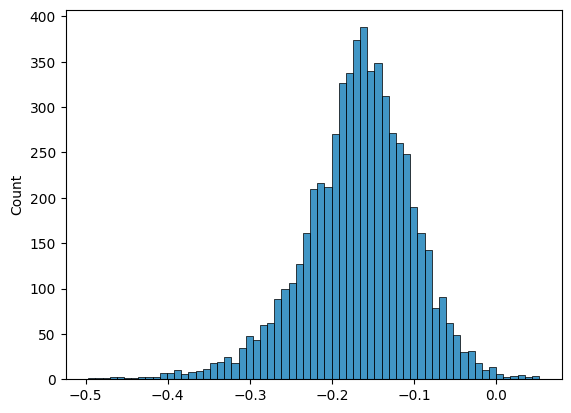

In [89]:
sns.histplot(d)

In [88]:
d = a['value'].to_numpy().flatten()

import scipy.stats as st

mean = np.mean(d)
std_dev = np.std(d, ddof=1)  # ddof=1 for sample standard deviation
n = len(d)

# Calculate critical value (using t-distribution for small sample size)
confidence_level = 0.96
alpha = 1 - confidence_level
dof = n - 1
t_critical = stats.t.ppf(1 - alpha/2, df=dof)

# Calculate margin of error
margin_of_error = t_critical * std_dev / np.sqrt(n)

# Calculate confidence interval
lower_bound = mean - margin_of_error
upper_bound = mean + margin_of_error

# Print the confidence interval
print(f"98% Confidence Interval: ({lower_bound}, {upper_bound})")

98% Confidence Interval: (-0.16981198693495836, -0.16627531707037496)


In [90]:
# Calculate percentiles
q1 = np.percentile(d, 2)
median = np.percentile(d, 50)  # also known as 50th percentile (median)
q3 = np.percentile(d, 98)

# Print the percentiles
print(f"25th Percentile (Q1): {q1}")
print(f"Median (50th Percentile): {median}")
print(f"75th Percentile (Q3): {q3}")

25th Percentile (Q1): -0.32754512
Median (50th Percentile): -0.1639675
75th Percentile (Q3): -0.04183103600000031


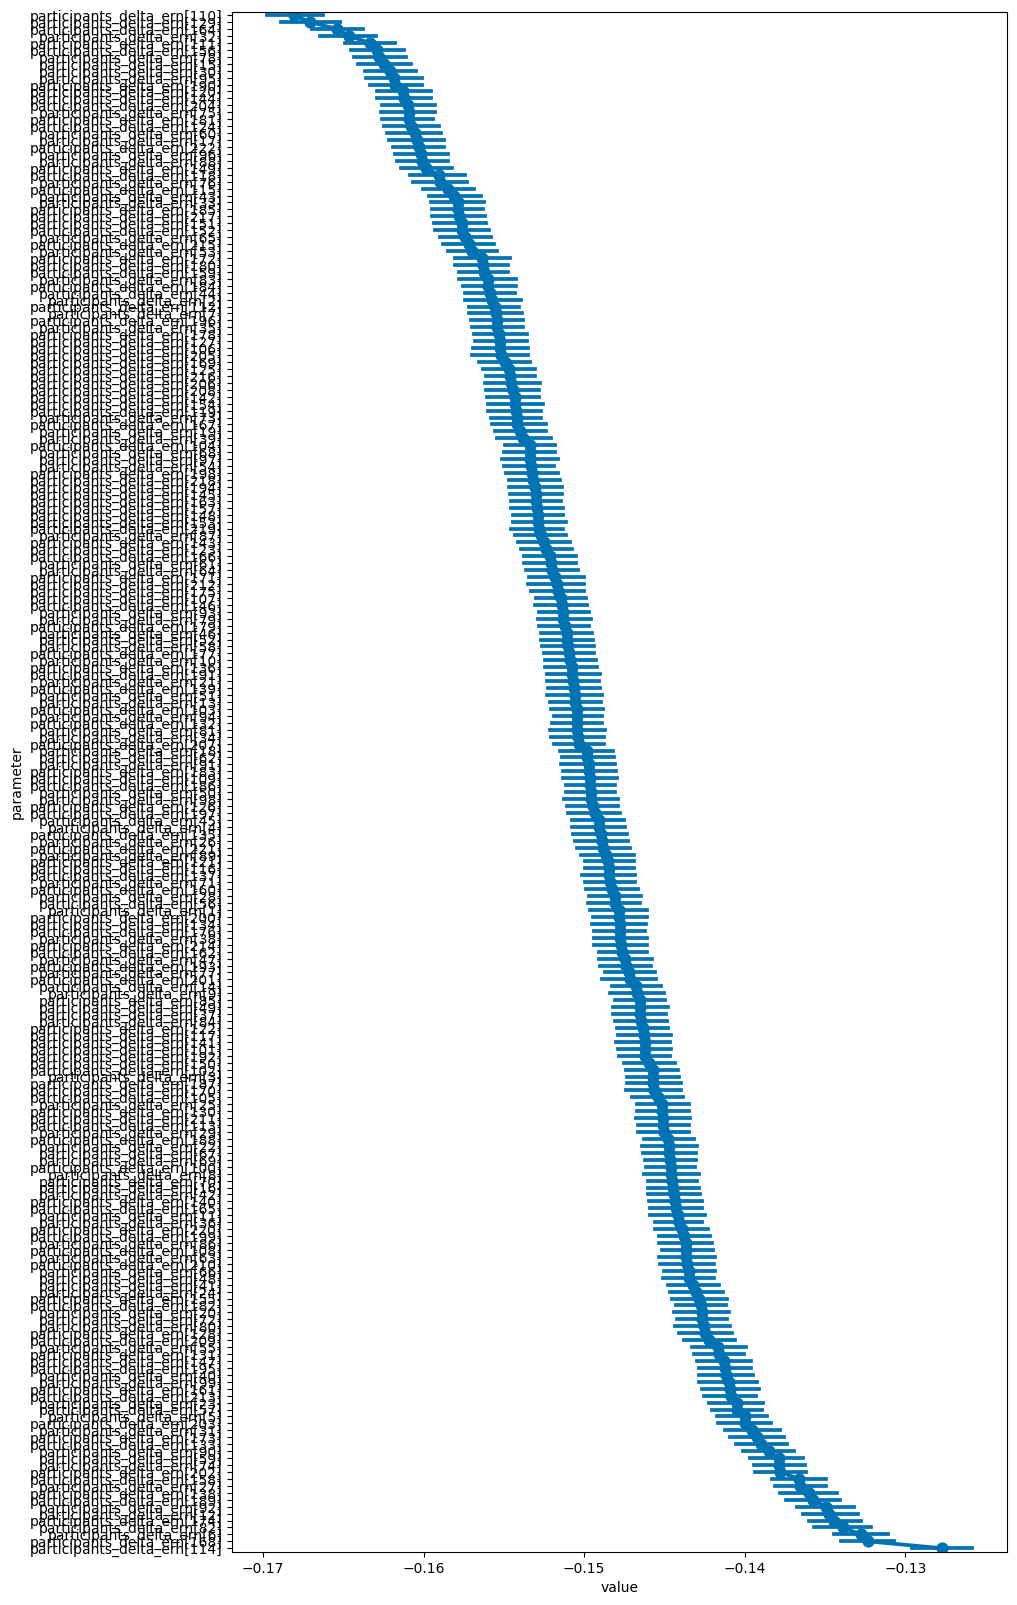

In [143]:
plt.figure(figsize=(10, 20))

sns.pointplot(data=grouped_df_sorted[grouped_df_sorted['parameter_name'] == 'participants_delta_ern'], y="parameter", x="value", errorbar="ci")

plt.show()

### Test priors

In [98]:
priors_dict = {
    'participants_delta_ne':[{
        'mean': {'loc':0, "scale":0.5},
        'sd': {'shape':0.3, "scale":1},
    }, True],
    'participants_alpha_ne_pre_acc':[{
        'mean': {'loc':0, "scale":0.2},
        'sd': {'shape':1, "scale":1},
    }, True],
    'participants_alpha_ern':[
        [
            {
                'mean': {'loc':0, "scale":0.2},
                'sd': {'shape':.3, "scale":1},
            },
            {
                'mean': {'loc':0, "scale":0.2},
                'sd': {'shape':.3, "scale":1},
            },
        ], 
        True
    ],
}

In [100]:
hyper_prior_distributions = priors_dict['participants_alpha_ern'][0]
N=10000

In [101]:
mean_hyper_prior = hyper_prior_distributions[0]['mean']
sd_hyper_prior = hyper_prior_distributions[0]['sd']

mean_samples = np.random.normal(loc=mean_hyper_prior['loc'], scale=mean_hyper_prior['scale'], size=(N,))
sd_samples = np.random.gamma(shape = sd_hyper_prior['shape'], scale=sd_hyper_prior['scale'], size=(N,))

prior_samples = []

for i in range(0,N):
    prior_sample = np.random.normal(loc=mean_samples[i], scale=sd_samples[i], size=None)
    prior_samples.append(prior_sample)
prior_samples = np.array(prior_samples)

x_vals = np.linspace(-1, 1, 1000)

# Prior density of hierarchical effect parameters
prior_density = stats.gaussian_kde(prior_samples)

parameter_kde = stats.gaussian_kde(fit.draws_pd()['participants_alpha_ern[110]'])

TypeError: list indices must be integers or slices, not str

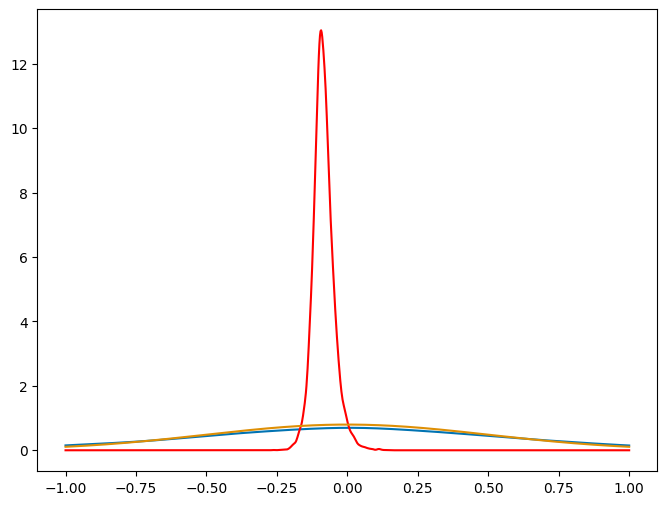

In [917]:
# Generate a range of values over which to evaluate the density

# Evaluate the density
y_vals = prior_density(x_vals)
y_sample_vals = parameter_kde(x_vals)
y_sample2_values = stats.norm.pdf(x_vals, loc=0, scale=0.5)


# Plot the density using matplotlib
plt.figure(figsize=(8, 6))
plt.plot(x_vals, y_vals, label='Gaussian KDE')
plt.plot(x_vals, y_sample_vals, label='Gaussian KDE', color='r')
plt.plot(x_vals, y_sample2_values, label='Gaussian KDE')

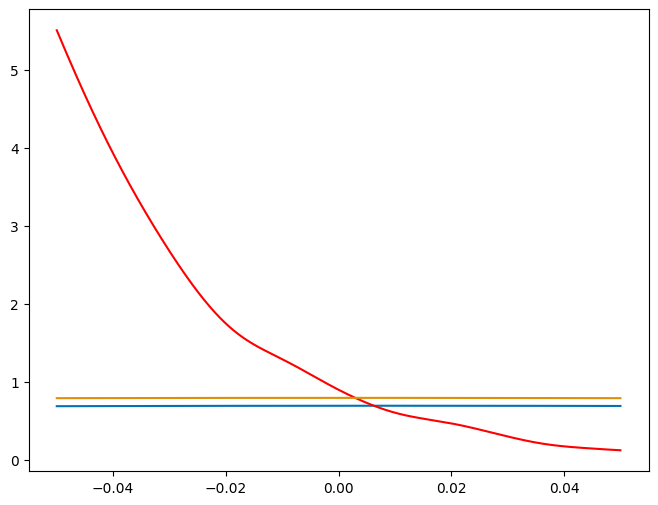

In [916]:
# Generate a range of values over which to evaluate the density
x_zoom = np.linspace(-0.05, 0.05, 1000)

y_vals = prior_density(x_zoom)
y_sample_vals = parameter_kde(x_zoom)
y_sample2_values = stats.norm.pdf(x_zoom, loc=0, scale=0.5)

# Plot the density using matplotlib
plt.figure(figsize=(8, 6))
plt.plot(x_zoom, y_vals, label='Gaussian KDE')
plt.plot(x_zoom, y_sample_vals, label='Gaussian KDE', color='r')
plt.plot(x_zoom, y_sample2_values, label='Gaussian KDE')

<Axes: ylabel='Count'>

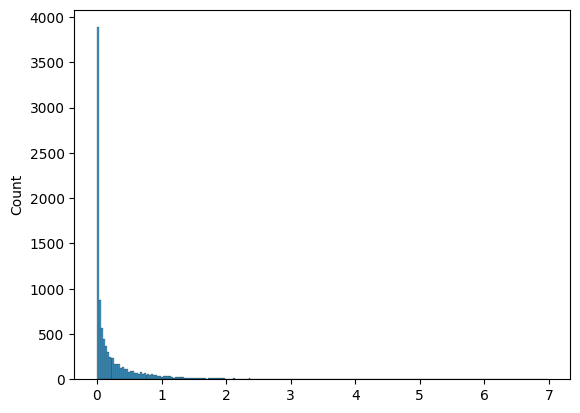

In [913]:
sns.histplot(sd_samples)

In [914]:
# Calculate Bayes Factors 01, evidence for the null hypothesis
bayes_factor_01 = parameter_kde(0) / prior_density(0)
print(bayes_factor_01)

bayes_factor_01 = parameter_kde(0) / stats.norm.pdf(0, loc=0, scale=0.2)
print(bayes_factor_01)

[1.29372555]
[0.4519894]


<Axes: xlabel='participants_delta_ern[209]', ylabel='Count'>

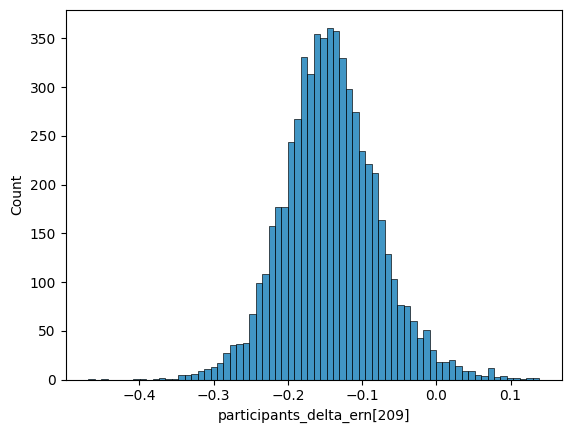

In [91]:
sns.histplot(fit.draws_pd()['participants_delta_ern[209]'])

# up to 10 - it is
# up to 25 - maybe
# above 25 - there is no

In [92]:
N = 100000
mean_samples_1 = np.random.normal(loc=0, scale=0.2, size=(N,))
mean_samples_2 = np.random.normal(loc=0, scale=0.5, size=(N,))

prior_samples =  np.concatenate((mean_samples_1, mean_samples_2))
x_vals = np.linspace(-1, 1, 100000)

# Prior density of hierarchical effect parameters
prior_density = stats.gaussian_kde(prior_samples)

In [93]:
# Evaluate the density
y_vals = prior_density(x_vals)
y_sample2_values = stats.norm.pdf(x_vals, loc=0, scale=0.2)

plt.figure(figsize=(8, 6))
plt.plot(x_vals, y_vals, label='Gaussian KDE')
# plt.plot(x_vals, y_sample2_values, label='Gaussian KDE')

KeyboardInterrupt: 

In [1091]:
len(prior_samples)

200000

In [1092]:
prior_density(0)

array([1.38394924])

In [1095]:
prior_kde = [stats.norm.pdf(0, loc=0, scale=0.2), stats.norm.pdf(0, loc=0, scale=0.5)]
prior_kde = np.mean(prior_kde)

In [1096]:
prior_kde

1.3962979814050145

In [132]:
priors_dict = {
    'participants_delta_ne':[{
        'mean': {'loc':0, "scale":0.5},
        'sd': {'shape':0.3, "scale":1},
    }, True],
    'participants_alpha_ne_pre_acc':[{
        'mean': {'loc':0, "scale":0.2},
        'sd': {'shape':1, "scale":1},
    }, True],
    'participants_delta_ern':[
        [
            {
                'mean': {'loc':0, "scale":0.2},
                'sd': {'shape':.3, "scale":1},
            },
            {
                'mean': {'loc':0, "scale":0.2},
                'sd': {'shape':.3, "scale":1},
            },
        ], 
        True
    ],
}

In [133]:
hyper_prior_distributions = priors_dict['participants_delta_ern'][0]
N=10000

In [134]:
hyper_prior_distributions

[{'mean': {'loc': 0, 'scale': 0.2}, 'sd': {'shape': 0.3, 'scale': 1}},
 {'mean': {'loc': 0, 'scale': 0.2}, 'sd': {'shape': 0.3, 'scale': 1}}]

In [135]:
prior_samples = []
for hyper_prior in hyper_prior_distributions:
    mean_hyper_prior = hyper_prior['mean']
    sd_hyper_prior = hyper_prior['sd']

    mean_samples = np.random.normal(loc=mean_hyper_prior['loc'], scale=mean_hyper_prior['scale'], size=(N,))
    sd_samples = np.random.gamma(shape = sd_hyper_prior['shape'], scale=sd_hyper_prior['scale'], size=(N,))

    for i in range(0,N):
        prior_sample = np.random.normal(loc=mean_samples[i], scale=sd_samples[i], size=None)
        prior_samples.append(prior_sample)
prior_samples = np.array(prior_samples)

In [136]:
# Prior density of hierarchical effect parameters
prior_density = stats.gaussian_kde(prior_samples)

parameter_kde = stats.gaussian_kde(fit.draws_pd()['participants_delta_ern[114]'])

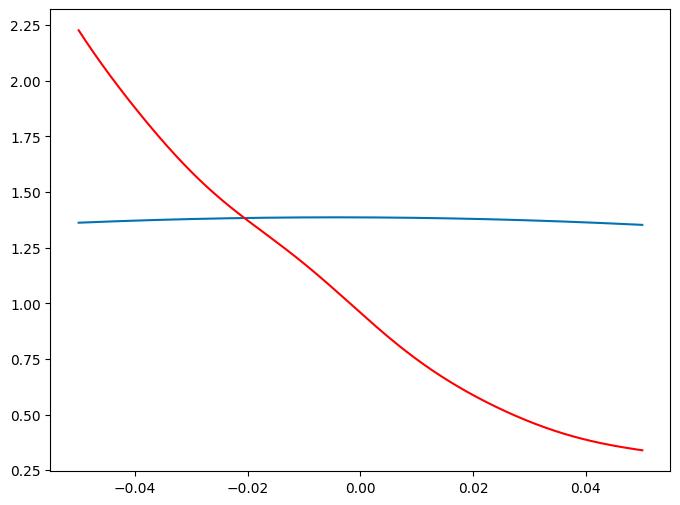

In [137]:
# Generate a range of values over which to evaluate the density
x_zoom = np.linspace(-0.05, 0.05, 2000)

y_vals = prior_density(x_zoom)
y_sample_vals = parameter_kde(x_zoom)
y_sample2_values = stats.norm.pdf(x_zoom, loc=0, scale=0.5)

# Plot the density using matplotlib
plt.figure(figsize=(8, 6))
plt.plot(x_zoom, y_vals, label='Gaussian KDE')
plt.plot(x_zoom, y_sample_vals, label='Gaussian KDE', color='r')
# plt.plot(x_zoom, y_sample2_values, label='Gaussian KDE')

<Axes: xlabel='participants_delta_ern[114]', ylabel='Count'>

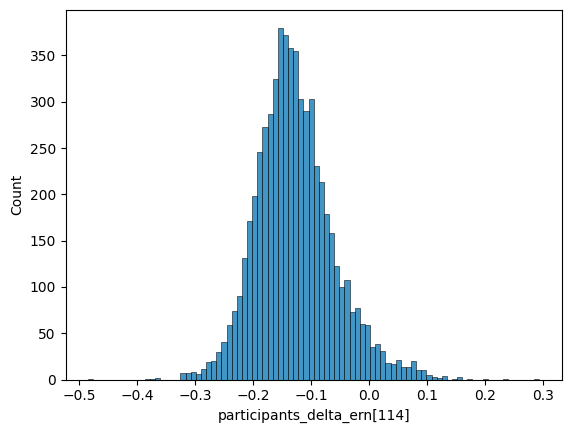

In [138]:
sns.histplot(fit.draws_pd()['participants_delta_ern[114]'])